# Calibrate, export and mask hyperspectral data

## Set folder

In [1]:
import os.path

from hyperspec.calib.bil_reader import BilReader

try:
    from _local import path_folder_iceland
    path_folder_capture = path_folder_iceland
except:  # provide the complete path to the folder with the raw data here (usually called 'capture')
     path_folder_capture = r'path/to/your/capture/folder'

assert os.path.exists(path_folder_capture), f'provided file {path_folder_capture} does not exist'

## RGB image
We start with setting up a file finder that finds the raw binary and header files for the withe and dark references and the actual data. We also initialize a reader with the files for the measurement.

In [2]:
from hyperspec.file_finder import FileFinder

ff = FileFinder(path_folder_capture)
bil_reader  = BilReader(
    path_file_header=ff.path_meas_header_file,
    path_file_binary=ff.path_meas_binary_file
)

For the RoI we will need some reference image, we use the red green and blue channels

In [3]:
rgb = bil_reader.get_rgb_img()

reading data for wavelength 475.44 nm: 100%|██████████| 8343/8343 [00:40<00:00, 207.70it/s] 


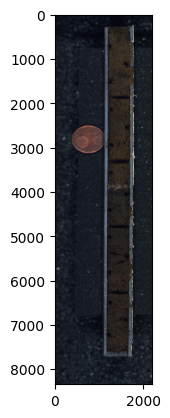

In [4]:
import matplotlib.pyplot as plt
plt.imshow(rgb)
plt.show()

## RoI definition
Tweak values of roi to only include the sediment. This is a bit tedious, I know ...

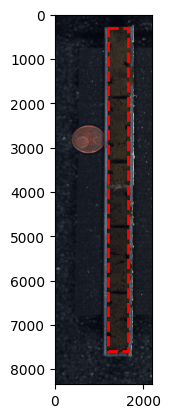

In [5]:
from matplotlib.patches import Rectangle
# xmin, xmax, ymin, ymax
roi = (1200, 1650, 290, 7600)
# roi = (250, 1000, 2300, 3200)
x_min, x_max, y_min, y_max = roi
width = x_max - x_min
height = y_max - y_min

rect = Rectangle((x_min, y_min), width, height,
                         linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
plt.imshow(rgb)
plt.gca().add_patch(rect)

Let's double check the RoI looks good

reading data for wavelength 475.44 nm: 100%|██████████| 7310/7310 [00:05<00:00, 1351.82it/s]


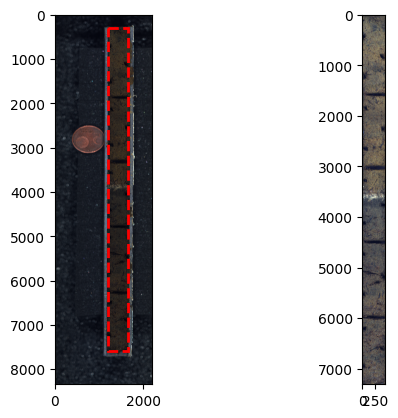

In [6]:
bil_reader.set_roi(*roi)
rect = Rectangle((x_min, y_min), width, height,
                         linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
rgb_roi = bil_reader.get_rgb_img()

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(rgb)
axs[0].add_patch(rect)
axs[1].imshow(rgb_roi)
plt.show()

## Calibration and export
We will store data in the hdf5 format after calibrating each line with the white and dark references.

### Get referecne images for defining limits

In [7]:
from hyperspec.calib import get_sensor_wise_average_fast

white_ref_bil = get_sensor_wise_average_fast(ff.path_white_ref_header_file, ff.path_white_ref_binary_file)
dark_ref_bil = get_sensor_wise_average_fast(ff.path_dark_ref_header_file, ff.path_dark_ref_binary_file)

if bil_reader.mask_roi_per_line is not None:
    white_ref_bil = white_ref_bil[bil_reader.mask_roi_per_line]
    dark_ref_bil = dark_ref_bil[bil_reader.mask_roi_per_line]

Calcing average reflectance of reference: 100%|██████████| 100/100 [00:02<00:00, 48.78it/s]


In [8]:
try:
    from _local import path_file_hdf5_iceland
    path_file_hdf5 = path_file_hdf5_iceland
except:  # set the path and name of where you want to store the hdf5 file (this file is big, so make sure you have enough space)
     path_file_hdf5 = 'path/to/your/hdf5/file.hdf5'

write the actual file scan by scan

In [9]:
from hyperspec.calib import write_calibrated_resampled_hdf
write_calibrated_resampled_hdf(path_file_hdf5, bil_reader, white_ref_bil, dark_ref_bil)

writing hdf: 100%|██████████| 7310/7310 [03:51<00:00, 31.64it/s]


from now on we will access data from the hdf5 file which is now calibrated and a lot faster to read in this format.

## Define background mask
We need to know where we have holes and cracks in the sediment in order to exclude them from further analysis. This time we will use the calibrated RGB image.

In [12]:
import numpy as np
import h5py
from tqdm import tqdm


def get_rgb_from_hdf5(path_file, bil_reader: BilReader):
    hdf = h5py.File(path_file, 'r')

    dataset = hdf['roi_calibrated']

    wavelengths = bil_reader.rgb_wavelengths
    idcs = np.array([np.argmin(np.abs(wv - bil_reader.wavelengths_nm)) for wv in wavelengths])
    roi_ = []
    for idx in tqdm(idcs, total=len(idcs), desc='reading RoI RGB channels'):
        roi_.append(dataset[:, :, idx])
    return np.stack(roi_, axis=-1)

In [13]:
roi_rgb = get_rgb_from_hdf5(path_file_hdf5, bil_reader)

reading RoI RGB channels: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


In [14]:
from skimage.color import rgb2gray
gray = rgb2gray(roi_rgb)

### define thresholds
We will manually set a threshold below which we consider pixels to be holes. Admittedly, this is much more convenient in napari-sediment

In [15]:
thresholds = [0.035]
regions = np.digitize(gray, thresholds)

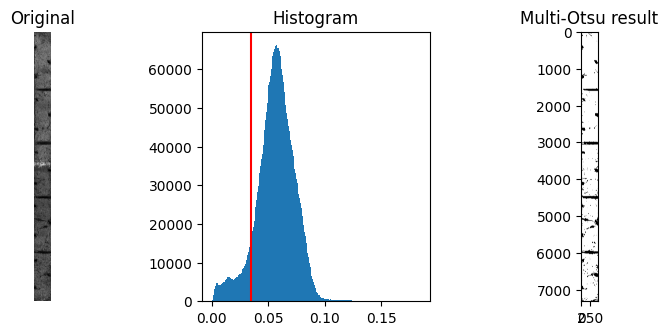

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu result')
# ax[2].axis('off')

plt.subplots_adjust()

plt.show()

### confine region further

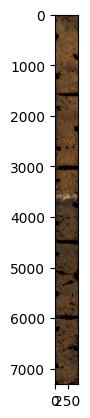

In [18]:
mask_sediment = (regions == 1)
plt.imshow(mask_sediment[:, :, None] * roi_rgb.astype(float) / roi_rgb.max())

We save the mask so that we can use it later

In [19]:
try:
    from _local import path_file_mask_foreground_iceland
    path_file_mask = path_file_mask_foreground_iceland
except Exception as e:
    print(e)
    print('please provide your path below')
    path_file_mask = 'path/to/your/mask.npy'

np.save(path_file_mask, mask_sediment)